In [1]:
import os, sys, time, resource, re, gc, shutil
from django.db.models import Count
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django



from scipy.spatial import ConvexHull

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from utils.text import *
from tmv_app.tasks import *
from scoping.models import *
from tmv_app.models import *
matplotlib.rcParams["figure.figsize"] = [7.2,4.5]
matplotlib.rcParams['axes.labelsize'] = 7 
matplotlib.rcParams['xtick.labelsize'] = 5
matplotlib.rcParams['ytick.labelsize'] = 5 


q = Query.objects.get(pk=2355)

docs = Doc.objects.filter(query=q,PY__lt=2018,PY__gt=1980)

In [2]:
docs_an = docs.values('PY').annotate(
    n_docs = Count('id'),
    n_journals = Count('wosarticle__so', distinct=True),
    n_authors = Count('docauthinst__AU', distinct=True),
    n_keywords = Count('wosarticle__de', distinct=True)
)

df = pd.DataFrame.from_dict(list(docs_an))

df.tail()

,PY,n_authors,n_docs,n_journals,n_keywords
32,2013,72660,136775,2982,19127
33,2014,79613,151410,3151,21032
34,2015,87932,172597,3291,23289
35,2016,97497,196837,3403,26194
36,2017,104985,217627,3396,28293


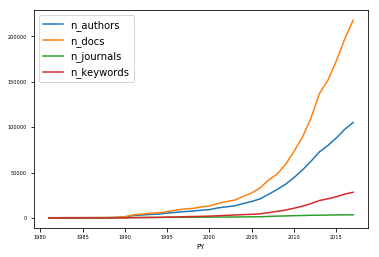

In [3]:
plt.close()
pdf = df.set_index('PY')
pdf.plot()

plt.show()

In [4]:
def get_year_words(row,docs):
    py = row['PY']
    docs = docs.filter(PY=py)
    abstracts, docsizes, ids, citations = proc_docs(docs, stoplist, False, False)
    try:
        count_vectorizer = CountVectorizer(
            min_df=5,
            max_features=100000,
            ngram_range=(1,1),
            stop_words=stoplist
        )
        tfidf = count_vectorizer.fit_transform(abstracts).shape[1]
    except:
        tfidf = 0
    return tfidf
    
abstracts = get_year_words({'PY':1990},docs)
df['n_words'] = df.apply(lambda x: get_year_words(x,docs),axis=1)

df.tail()

,PY,n_authors,n_docs,n_journals,n_keywords,n_words
32,2013,72660,136775,2982,19127,20580
33,2014,79613,151410,3151,21032,21674
34,2015,87932,172597,3291,23289,22710
35,2016,97497,196837,3403,26194,23836
36,2017,104985,217627,3396,28293,24790


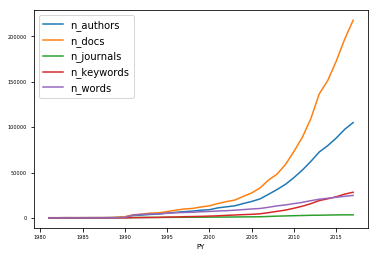

In [9]:
plt.close()
pdf = df.set_index('PY')
pdf.plot()
plt.savefig('../plots/vs.png')
plt.show()

In [8]:

df.to_csv('../data/vs.csv',index=False)